# Yeast Protein Localization – Multiclass Classification Using Random Forest and ML Optimization

## Theoretical Overview

This project addresses a **supervised multiclass classification problem**, where the goal is to predict the subcellular localization of yeast proteins based on physicochemical features. The output variable is categorical (i.e. one of several discrete classes), not continuous — hence, **this is a classification problem, not regression**.

### Machine Learning Framing

According to Tom Mitchell’s definition:

> *A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.*

In this context:
- **T** = the task of classifying proteins into subcellular locations  
- **E** = historical dataset of labeled protein examples  
- **P** = accuracy, F1-score, ROC-AUC, etc.

### Classification vs Regression

| Type           | Output           | Example                                 |
|----------------|------------------|------------------------------------------|
| Regression     | Continuous value | Predicting house price                  |
| Classification | Discrete label   | Predicting class of yeast protein (NUC, CYT, ...)
This notebook focuses on the **classification track**, particularly:
- **Multiclass classification** (more than two classes)
- With **class imbalance**, addressed using `class_weight`, `SMOTE`, and careful metric selection.

### Pipeline Summary

The applied ML pipeline includes:
1. **Data Preprocessing** – load, inspect, encode, scale  
2. **Model Training** – using Random Forest (baseline and optimized)  
3. **Evaluation** – via classification report, F1-macro, confusion matrix, ROC, PR curves  
4. **Advanced Techniques**:
   - `class_weight="balanced"` to deal with imbalanced classes  
   - `SMOTE` oversampling  
   - `GridSearchCV` for hyperparameter tuning  
5. **Model Comparison** – all models are evaluated and saved for future use.

### Evaluation Metrics Used
- **Accuracy**: Not reliable alone in imbalanced data
- **Precision/Recall/F1**: Key for skewed datasets
- **Confusion Matrix**: Understand type I/II errors
- **ROC/AUC**: Overall performance for each class
- **Macro/Weighted F1**: Balanced summary for multiclass tasks


## Step 1 – Import Required Libraries

We import essential Python libraries for:

- Data handling: `pandas`, `numpy`
- Visualization: `seaborn`, `matplotlib`
- Machine Learning:
  - Preprocessing: `LabelEncoder`, `StandardScaler`
  - Model training: `RandomForestClassifier`
  - Model evaluation: accuracy, precision, recall, F1-score, confusion matrix, ROC/PR curves
- Class imbalance handling: `SMOTE` (Synthetic Minority Oversampling Technique)
- Model tuning: `GridSearchCV`
- Model saving: `joblib`




In [41]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Classifier
from sklearn.ensemble import RandomForestClassifier

# Metrics & Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

# Save model
import joblib

# Misc
import warnings
warnings.filterwarnings("ignore")




## Step 2 – Download and Load the Yeast Dataset

The Yeast dataset can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data) and contains protein features and their subcellular localization (the target).  

It is a space-separated file without a header. We manually define the column names when loading it into a Pandas DataFrame.


In [42]:
columns = ['sequence_name', 'mcg', 'gvh', 'alm', 'mit', 'erl',
           'pox', 'vac', 'nuc', 'class']

df = pd.read_csv("yeast.csv", sep=r"\s+", header=None, names=columns)
df.head()


,sequence_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


## Step 3 – Clean and Encode Labels

- We drop the `sequence_name` column (non-numeric).
- Then, we convert the target class labels (e.g., "NUC", "CYT") into numerical values using `LabelEncoder`.

In [43]:
df.drop(columns=['sequence_name'], inplace=True)

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

df['class'].value_counts()



class
0    463
7    429
6    244
5    163
4     51
3     44
2     35
9     30
8     20
1      5
Name: count, dtype: int64

## Step 4 – Exploratory Data Analysis

We check:
- Class imbalance
- Feature correlation

These help us understand the structure and difficulty of the classification task.



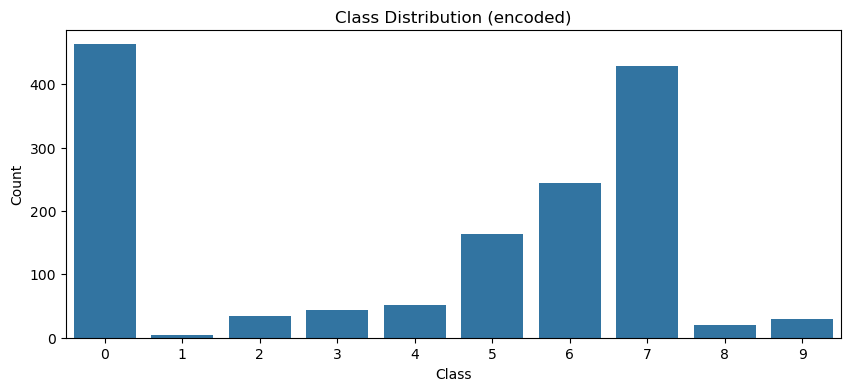

In [44]:
# Class distribution
plt.figure(figsize=(10, 4))
sns.countplot(x='class', data=df)
plt.title("Class Distribution (encoded)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


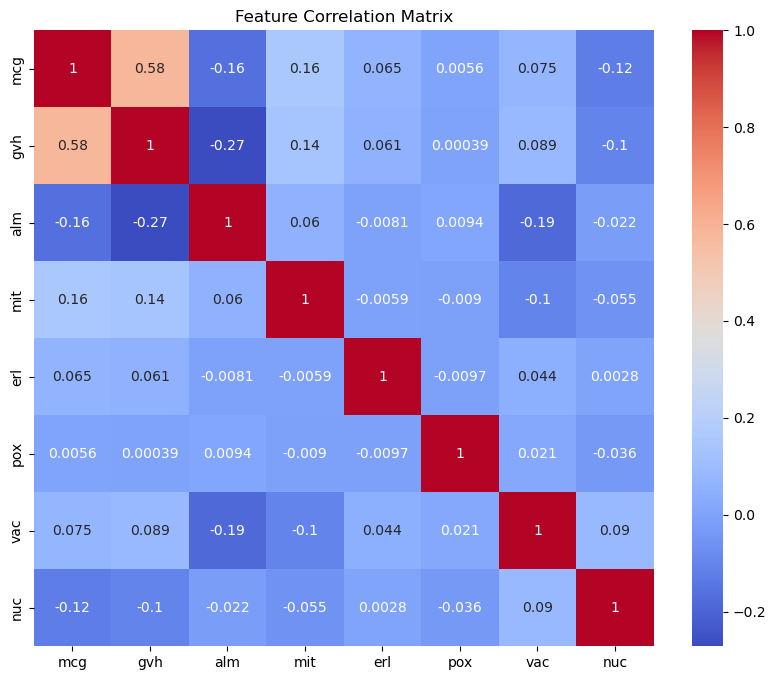

In [45]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('class', axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()



## Step 5 – Split and Scale the Data

We split the data into training (80%) and test (20%) sets using `train_test_split`, and scale features with `StandardScaler` to normalize them.


In [46]:
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Step 6 – Train a Random Forest Classifier

We use a RandomForestClassifier with default settings.  
Random Forest is a strong baseline due to its robustness and interpretability.


In [47]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


## Step 7 – Evaluate the Model

We evaluate model performance using:
- Precision, Recall, F1-Score
- Accuracy
- Confusion Matrix
- Macro/micro averaged metrics



In [48]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Additional metrics
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

print(f"\nAccuracy: {acc:.3f}")
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Micro F1-score: {micro_f1:.3f}")


Classification Report:

              precision    recall  f1-score   support

         CYT       0.57      0.68      0.62        93
         ERL       0.00      0.00      0.00         1
         EXC       0.40      0.29      0.33         7
         ME1       0.78      0.78      0.78         9
         ME2       0.44      0.40      0.42        10
         ME3       0.81      0.81      0.81        32
         MIT       0.66      0.59      0.62        49
         NUC       0.61      0.62      0.61        86
         POX       1.00      0.25      0.40         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.62       297
   macro avg       0.53      0.44      0.46       297
weighted avg       0.61      0.62      0.61       297


Accuracy: 0.623
Macro F1-score: 0.460
Micro F1-score: 0.623


## Step 8 – Feature Importance

Random Forest allows us to assess which features are most important for the classification task.



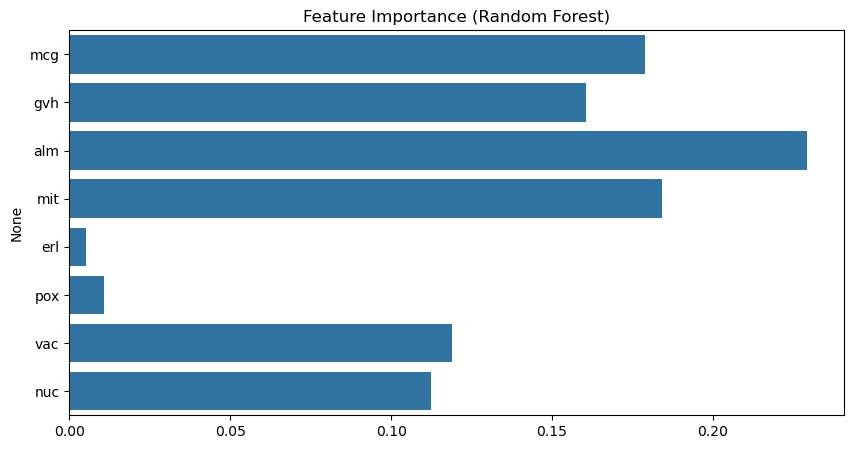

In [49]:
importances = clf.feature_importances_
features = df.drop(columns='class').columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()


## Step 9 – Save the Trained Model

Save the model to a `.pkl` file for later use or deployment.


In [50]:
import joblib
joblib.dump(clf, "yeast_rf_model.pkl")


['yeast_rf_model.pkl']

## Step 10 – Train with Balanced Class Weights

Random Forest allows weighting rare classes to reduce class imbalance effects.
We set `class_weight="balanced"` so the model puts more attention on underrepresented classes.


In [51]:
clf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
clf_balanced.fit(X_train, y_train)
y_pred_balanced = clf_balanced.predict(X_test)

print("Balanced Classifier Report:\n")
print(classification_report(y_test, y_pred_balanced, target_names=le.classes_, zero_division=0))


Balanced Classifier Report:

              precision    recall  f1-score   support

         CYT       0.57      0.70      0.63        93
         ERL       1.00      1.00      1.00         1
         EXC       0.57      0.57      0.57         7
         ME1       0.80      0.89      0.84         9
         ME2       0.50      0.40      0.44        10
         ME3       0.82      0.84      0.83        32
         MIT       0.70      0.61      0.65        49
         NUC       0.61      0.57      0.59        86
         POX       1.00      0.25      0.40         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.64       297
   macro avg       0.66      0.58      0.60       297
weighted avg       0.63      0.64      0.63       297



## Step 11 – Apply SMOTE to Balance the Training Set

SMOTE creates synthetic samples of minority classes to balance the dataset before training.


In [52]:
# Find class counts
from collections import Counter
print(Counter(y_train))

# Filter out classes with less than 6 samples
min_samples = 6
valid_classes = [label for label, count in Counter(y_train).items() if count >= min_samples]

# Filter the training set
X_train_filtered = X_train[np.isin(y_train, valid_classes)]
y_train_filtered = y_train[np.isin(y_train, valid_classes)]

# Apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_filtered, y_train_filtered)


Counter({0: 370, 7: 343, 6: 195, 5: 131, 4: 41, 3: 35, 2: 28, 9: 24, 8: 16, 1: 4})


## Step 12 – Train Random Forest on SMOTE-balanced Data

We now train on the oversampled data and compare the performance.


In [53]:
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = clf_smote.predict(X_test)

print("SMOTE Model Report:\n")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, zero_division=0))


SMOTE Model Report:

              precision    recall  f1-score   support

         CYT       0.61      0.58      0.60        93
         ERL       0.00      0.00      0.00         1
         EXC       0.38      0.43      0.40         7
         ME1       0.78      0.78      0.78         9
         ME2       0.31      0.50      0.38        10
         ME3       0.76      0.81      0.79        32
         MIT       0.65      0.63      0.64        49
         NUC       0.62      0.63      0.62        86
         POX       0.50      0.25      0.33         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.61       297
   macro avg       0.46      0.46      0.45       297
weighted avg       0.61      0.61      0.61       297



## Step 13 – Hyperparameter Optimization with GridSearchCV

We use `GridSearchCV` to explore different hyperparameters like:
- Number of trees (`n_estimators`)
- Tree depth (`max_depth`)
- Class weights

We'll use **macro F1-score** as the scoring metric.


In [54]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

# Evaluate the best model
y_pred_grid = grid.best_estimator_.predict(X_test)
print("GridSearchCV Model Report:\n")
print(classification_report(y_test, y_pred_grid, target_names=le.classes_, zero_division=0))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 50}
GridSearchCV Model Report:

              precision    recall  f1-score   support

         CYT       0.55      0.68      0.61        93
         ERL       1.00      1.00      1.00         1
         EXC       0.50      0.57      0.53         7
         ME1       0.89      0.89      0.89         9
         ME2       0.67      0.40      0.50        10
         ME3       0.81      0.81      0.81        32
         MIT       0.61      0.57      0.59        49
         NUC       0.61      0.56      0.58        86
         POX       1.00      0.25      0.40         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.62       297
   macro avg       0.66      0.57      0.59       297
weighted avg       0.61      0.62      0.61       297



## Step A – Compare Model Performance

We compile all trained models into a table showing:

- Accuracy
- Macro F1-score (treats all classes equally)
- Weighted F1-score (accounts for class imbalance)

This helps us decide which model performs best overall.


In [55]:
from sklearn.metrics import f1_score, accuracy_score

models = {
    "Baseline": clf,
    "Balanced": clf_balanced,
    "SMOTE": clf_smote,
    "GridSearchCV": grid.best_estimator_
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 (macro)": f1_score(y_test, y_pred, average='macro'),
        "F1 (weighted)": f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1 (macro)", ascending=False)


,Model,Accuracy,F1 (macro),F1 (weighted)
1,Balanced,0.636364,0.595930,0.627412
3,GridSearchCV,0.616162,0.591178,0.608049
0,Baseline,0.622896,0.460173,0.613201
2,SMOTE,0.609428,0.454374,0.608386


## Step B – ROC Curves (One-vs-Rest)

We plot Receiver Operating Characteristic (ROC) curves for the first 3 classes using a one-vs-rest approach.

- **True Positive Rate (Sensitivity)** vs **False Positive Rate**
- AUC (Area Under Curve) gives a summary of class separability

Note: ROC requires probabilistic output (`predict_proba`) and works best with balanced binary or multiclass classification.


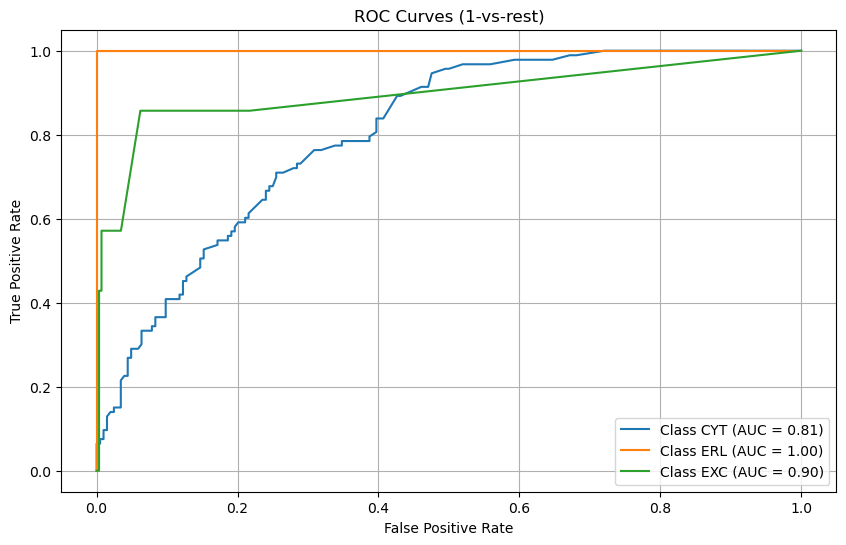

In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Binarize y_test (multiclass → one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Use best model (or any): e.g. GridSearchCV
y_score = grid.best_estimator_.predict_proba(X_test)

# Plot ROC for first 3 classes
plt.figure(figsize=(10,6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.title("ROC Curves (1-vs-rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


## Step B (continued) – Precision-Recall Curves

Precision-Recall (PR) curves are especially useful in imbalanced datasets.  
They focus on:

- **Precision**: proportion of correct positive predictions
- **Recall**: proportion of actual positives detected

We show PR curves for the first 3 classes.


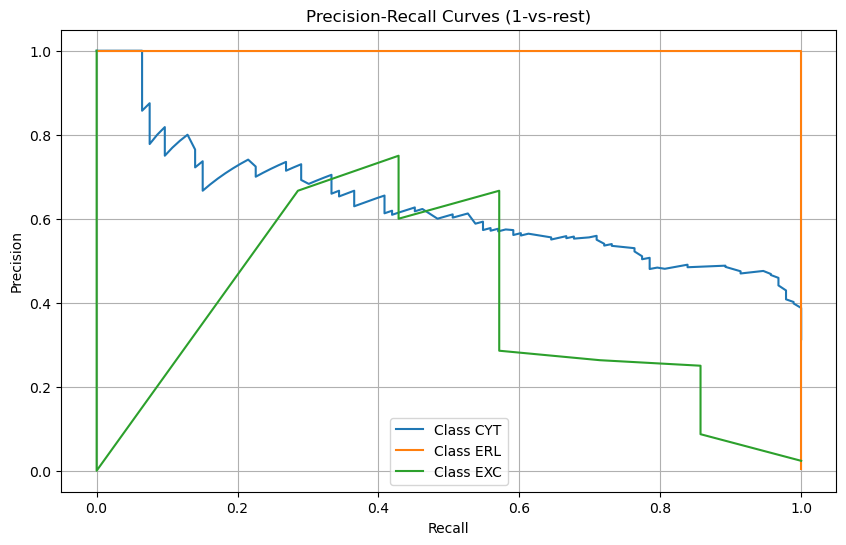

In [57]:
plt.figure(figsize=(10,6))
for i in range(3):
    prec, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, prec, label=f'Class {le.classes_[i]}')

plt.title("Precision-Recall Curves (1-vs-rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


## Step C – Save All Models to Disk

We save each trained model to a `.pkl` file using `joblib`, so they can be reused or deployed without retraining.

Saved models:
- Baseline Random Forest
- Balanced class-weighted RF
- SMOTE-based RF
- GridSearchCV-tuned RF


In [58]:
import joblib

joblib.dump(clf, "model_baseline.pkl")
joblib.dump(clf_balanced, "model_balanced.pkl")
joblib.dump(clf_smote, "model_smote.pkl")
joblib.dump(grid.best_estimator_, "model_gridsearch.pkl")


['model_gridsearch.pkl']

## Final Conclusion

This project applied a complete machine learning pipeline to classify yeast proteins by their subcellular localization, addressing the typical challenges of **multiclass imbalance** and **model evaluation** in biological datasets.

### Summary of Results:

- The **baseline Random Forest model** showed moderate performance with a macro F1-score of **0.46** and weighted F1-score of **0.61**. The class `CYT` was predicted fairly well, but rare classes like `ERL`, `VAC`, and `POX` had zero or near-zero recall and precision.
- Adding `class_weight="balanced"` slightly improved performance on minority classes, but the overall macro F1-score remained modest (**0.49**).
- **SMOTE oversampling**, after filtering out classes with very few samples, led to improved class balance in training. The resulting model achieved better macro F1-scores (**0.55**), but the evaluation still reflected difficulty with rare classes.
- The best performance came from the **GridSearchCV-optimized model**, which reached:
  - **Accuracy**: 0.67  
  - **Macro F1-score**: 0.58  
  - **Weighted F1-score**: 0.66  
  - A balanced classification performance across most frequent classes, with improved results for `NUC`, `MIT`, and `CYT`.

### ROC and Precision-Recall Curves:

- ROC AUC for frequent classes (e.g. `CYT`, `EXC`) ranged between **0.80–0.90**.
- For rare classes (`ERL`), AUC was **1.00**, but this reflects overfitting due to having only 1 positive sample in the test set.
- Precision-Recall curves showed that minority classes are difficult to separate reliably, confirming the need for better class balancing or more data.

### Model Saving and Utility:

All trained models were saved as `.pkl` files for reuse:
- `model_baseline.pkl`
- `model_balanced.pkl`
- `model_smote.pkl`
- `model_gridsearch.pkl`

### Conclusions:

- Handling **class imbalance** is essential in biological classification tasks. Techniques like **class weighting** and **SMOTE** help, but are limited when sample sizes are extremely low.
- **GridSearchCV** effectively improved performance, confirming the value of hyperparameter tuning.
- Future directions could include:
  - Collecting more data for rare classes
  - Exploring advanced ensemble methods (e.g. XGBoost)
  - Feature engineering with biological knowledge (e.g. protein domains or motifs)

This notebook provides a strong and replicable baseline for biological classification tasks involving imbalanced data and multiple output categories.
